In [4]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

In [5]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

In [6]:
from ipysankeywidget import SankeyWidget
# from ipywidgets import Layout
from IPython.display import SVG
import holoviews as hv
hv.notebook_extension()

In [8]:
%%time

dataset_name = "W13_only"

manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

dataset_filename = manifest["Stata_Filename"].values[0]
# dataset_description = manifest["Friendlier_Description"].values[0]
# dataset_citation = manifest["Citation"].values[0]
# dataset_start = manifest["Date_Start"].values[0]
# dataset_stop = manifest["Date_Stop"].values[0]
# dataset_wave = manifest["Wave No"].values[0]

BES_Panel = pd.read_stata( data_subfolder + dataset_filename )
print("BES_Panel", BES_Panel.shape )

####

BES_numeric = pd.read_hdf( data_subfolder + "BESnumeric.hdf", "BESnumeric" )
print("BES_numeric",  BES_numeric.shape )

var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
var_type.set_index("Unnamed: 0", inplace=True)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
    
####

BES_non_numeric = pd.read_hdf( data_subfolder + "BESnon_numeric.hdf", "BESnon_numeric" )
print("BES_non_numeric",  BES_non_numeric.shape )

# BES_reduced = pd.read_hdf( data_subfolder + "BES_reduced.hdf", "BES_reduced" )
# print("BES_reduced",  BES_reduced.shape )

# BES_reduced_with_na = pd.read_hdf( data_subfolder + "BES_reduced_with_na.hdf", "BES_reduced_with_na")
# print("BES_reduced_with_na", BES_reduced_with_na.shape )

# fname = data_subfolder + "new_old_col_names.pkl"
# with open(fname, "rb") as f:
#     new_old_col_names = pickle.load(f) 

BES_Panel (31197, 312)
BES_numeric (31197, 299)
var_type (312, 13)
BES_non_numeric (31197, 11)
Wall time: 3.22 s


In [2]:
# import numpy as np
# import pandas as pd
# %matplotlib inline
# import matplotlib.pyplot as plt
# from matplotlib import colors
# import gc
# import re

# from sklearn import datasets
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from itertools import cycle
# from IPython.display import display
# import pickle, os

# import seaborn as sns

# BES_data_folder = "../BES_analysis_data/"
# BES_code_folder = "../BES_analysis_code/"

# # from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE

In [3]:
# gc.collect()

In [3]:
# # %%time # 10 mins
# # load BES Panel for Wave 10
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W10_Panel_v0.3.dta")
# # big!
# print( BES_Panel.shape )

(64689, 4247)


In [3]:
# %%time
# # Load BES Panel for Wave 8
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
# #(31409, 733)

# # BES_Panel = pd.read_stata(BES_data_folder+BES2015_W8_v1.6.dta")

# print( BES_Panel.shape )

# read back in later with this
# BES_Panel= pd.read_pickle("BES_W10_small.pkl")

(31409, 733)
Wall time: 12.6 s


In [4]:
# for development, lets pare down the BES_Panel dataset to just the columns we're working with now
cols = ['profile_past_vote_2005',
        'profile_past_vote_2010',
        'profile_past_vote_2015',
        'al_scaleW10','al1W10','al2W10','al3W10','al4W10','al5W10',
        'lr_scaleW10','lr1W10','lr2W10','lr3W10','lr4W10','lr5W10',
        'marital', 'profile_education_age', 'profile_ethnicity',
        'gender', 'profile_household_size', 'housing',
        'profile_newspaper_readership_201', 'profile_household_children',
        'profile_gross_household', 'profile_gross_personal',
        'edlevel','ageGroup','country','countryOfBirth',
        'personality_agreeableness', 'personality_conscientiousness',
        'personality_extraversion', 'personality_neuroticism',
        'personality_openness',
        "euRefVoteW1","euRefVoteW2","euRefVoteW3",
        "euRefVoteW4","euRefVoteW6","euRefVoteW8","euRefVoteW10"]

for wave in ["W1","W2","W3","W4","W5","W6","W8","W10"]:
    cols.append( "generalElectionVote"+wave )
    cols.append( "wave" + wave.replace("W","") )
    cols.append( "wt_full_"+wave )
    
BES_Panel[cols].to_pickle("BES_W10_small.pkl")

# read back in later with this
# BES_Panel= pd.read_pickle("BES_W10_small.pkl")

In [9]:
party_list = list( BES_Panel[ ['profile_past_vote_2005','profile_past_vote_2010','profile_past_vote_2015' ] ].stack().unique() )
party_list.append('I would not vote')
replace_dict = {'Labour Party':"LAB", 
 'United Kingdom Independence Party (UKIP)':"UKIP",
 'Labour':"LAB",
 'Conservative Party':"CON",
 'Conservative':"CON",
 'Liberal Democrats':"LD",
 'Did not vote':"DNV",
 'Scottish National Party':"SNP",
 'Scottish National Party (SNP)':"SNP",
 'British National Party (BNP)':"BNP",
 'Green Party':"GP",
 'Liberal Democrat':"LD",
 "Don't know":"DK",
 'Some other party':"OTH",
 'Veritas':"VER",
 'Plaid Cymru':"PC",
 'Other':"OTH",
 'Respect':"RES",
 'I would not vote':"DNV"}
colourmap = {'LAB':'red', 'UKIP':'purple', 'CON':'blue', 'SNP':'yellow', 'BNP':'black', 'LD':'orange', 'DNV':'grey', 'DK':'cyan', 'OTH':'brown', 'GP':'green',
       'VER':'pink', 'PC':'olive', 'RES':'peru'}
base_order = ['LAB','CON','DK','UKIP','LD','SNP','DNV','GP','PC','BNP','OTH','RES','VER']
lr_order   = ['GP','PC','LAB','SNP','DK','OTH','DNV','LD','CON','UKIP','BNP','RES','VER']
cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru']

KeyError: "['profile_past_vote_2005' 'profile_past_vote_2010'] not in index"

In [12]:
[x for x in BES_Panel.columns if "profile_past" in x]

['profile_past_vote_2015']

In [6]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

def make_sankey(BES, links, order, first_year, second_year, first_col, second_col,
                replace_dict, threshold, colour, fixed_order, scale, nodes):
    
    crosstab = pd.crosstab(index   = BES[ first_col  ],
                           columns = BES[ second_col ],
                           values  = BES[ "wt_full_W10" ],
                           aggfunc = sum,
                           normalize=True)*scale
#     if order == []: # initialise
#         order = [ [[replace_dict[x]+first_year] for x in crosstab.index] ]
#     order.append( [[replace_dict[x]+second_year] for x in crosstab.columns] ) # add new layer
#     if nodes == []: # initialise
#         nodes =   [ {'id':x+first_year } for x in lr_order ]  #, 'direction':'r'
#     nodes.extend( [ {'id':x+second_year} for x in lr_order ] ) # , 'direction':'r'
    
    if order == []: # initialise
        order = [ [[x+first_year]  for x in fixed_order] ]
    order.append( [[x+second_year] for x in fixed_order] ) # add new layer
    
    for col in crosstab.columns:
        second_party = replace_dict[ col ]
        for ind in crosstab[col].index:
            first_party = replace_dict[ ind ]
            
            if crosstab[col][ind]>threshold:
                if colour == []:
                    col_to_use = colourmap[first_party]
                else:
                    col_to_use = cmap[colour]
                    
                node_id_first = first_party+first_year
                if node_id_first not in [x['id'] for x in nodes]:
                    nodes.append({'id':node_id_first, 'direction':'l'})
                node_id_second = second_party+second_year
                if node_id_second not in [x['id'] for x in nodes]:
                    nodes.append({'id':node_id_second, 'direction':'l'})                    

                d = {'source': node_id_first,
                     'target': node_id_second,
                     'value': crosstab[col][ind],
                     'color': col_to_use,'type' : colour}
                links.append(d)

    return links, order, nodes

In [7]:
threshold = 0.5
margins=dict(top=30, bottom=0, left=70, right=70)

In [215]:
# 2005 -> 2010, weighted
colour = []
order  = []
links  = []
pairs = (["2005",'profile_past_vote_2005'],
         ["2010",'profile_past_vote_2010'])
for pair_no in range(0,len(pairs)-1):
    (links,order) = make_sankey(BES_Panel, links, order,
                        pairs[pair_no][0], pairs[pair_no+1][0], pairs[pair_no][1], pairs[pair_no+1][1],
                        replace_dict, threshold, colour, lr_order)

SankeyWidget(links=links, order=order, margins = margins, scale=2)

In [216]:
# 2010 -> 2015, weighted
links = []
order = []
colour = []
pairs = (["2010",'profile_past_vote_2010'],
         ["2015",'profile_past_vote_2015'])
for pair_no in range(0,len(pairs)-1):
    (links,order) = make_sankey(BES_Panel, links,order,
                        pairs[pair_no][0], pairs[pair_no+1][0], pairs[pair_no][1], pairs[pair_no+1][1],
                        replace_dict, threshold, colour, lr_order)

SankeyWidget(links=links, order=order, margins=margins,scale=2)

In [228]:
links  = []
order  = []
colour = []
pairs = (["2005",'profile_past_vote_2005'],
         ["2010",'profile_past_vote_2010'],
         ["2015",'profile_past_vote_2015'],
         ["2017",'generalElectionVoteW10'])
for pair_no in range(0,len(pairs)-1):
    (links,order) = make_sankey(BES_Panel, links,order,
                        pairs[pair_no][0], pairs[pair_no+1][0], pairs[pair_no][1], pairs[pair_no+1][1],
                        replace_dict, threshold, colour, lr_order)

sankey = SankeyWidget(links=links, order=order, margins=margins, scale=2)
sankey


In [229]:
sankey.save_png(filename="PastElectionVote+2007intention.png")

In [ ]:
# links = []
# pairs = (["2005",'profile_past_vote_2005'],
#          ["2010",'profile_past_vote_2010'],
#          ["2015",'profile_past_vote_2015'],
#          ["2017",'generalElectionVoteW10'])
# for pair_no in range(0,len(pairs)-1):
#     links = make_sankey(BES_Panel, links,
#                         pairs[pair_no][0], pairs[pair_no+1][0], pairs[pair_no][1], pairs[pair_no+1][1],
#                         replace_dict, threshold, [])

# sankey = SankeyWidget(links=links, width=1600, height=800, margins=dict(top=0, bottom=0, left=70, right=70),scale=2)
# sankey
# sankey.save_png(filename="2005-2017.png")

In [223]:
links  = []
order  = []
colour = []
waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
for wave_no in range(0, len(waves)-1):
    
    (links, order) = make_sankey(BES_Panel, links, order,
                        waves[wave_no], waves[wave_no+1],
                        'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                        replace_dict, threshold, colour, lr_order)

SankeyWidget(links=links, order=order, margins=margins, scale=2)

In [224]:
sankey = SankeyWidget(links=links, order=order, margins=margins, scale=2)
sankey

In [225]:
sankey.save_png(filename="VotingIntentions2014-2017.png")

In [190]:
SankeyWidget(links=links, width=1600, height=800, margins=dict(top=0, bottom=0, left=70, right=70),scale=2)

In [236]:
links  = []
order  = []
colour = []
pairs = (["2005",'profile_past_vote_2005'],
         ["2010",'profile_past_vote_2010'],
         ["W1",'generalElectionVoteW1'])
for pair_no in range(0,len(pairs)-1):
    (links, order) = make_sankey(BES_Panel, links, order,
                        pairs[pair_no][0], pairs[pair_no+1][0],
                        pairs[pair_no][1], pairs[pair_no+1][1],
                        replace_dict, threshold, colour, lr_order)

waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
for wave_no in range(0, len(waves)-1):
    
    (links, order) = make_sankey(BES_Panel, links, order,
                        waves[wave_no], waves[wave_no+1],
                        'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                        replace_dict, threshold, colour, lr_order)

sankey = SankeyWidget(links=links, order=order, margins=margins, scale=2)
sankey

In [237]:
sankey.save_png(filename="Votes_and_VotingIntentions2005-2017.png")

In [305]:
threshold = 0.5
margins=dict(top=30, bottom=0, left=70, right=70)
links  = []
order  = []
colour = []

parties = BES_Panel['profile_past_vote_2005'].dropna().unique()
#parties = ['Labour Party', 'Conservative Party', 'Did not vote', 'United Kingdom Independence Party (UKIP)']
#parties = ['Labour Party']

for party in parties:
    order  = []
    BES = BES_Panel.loc[ BES_Panel['profile_past_vote_2005']==party ]
    scale = 100 * BES.shape[0]/BES_Panel.shape[0]
    #scale = 100
    colour = colourmap[replace_dict[party]]
    
    pairs = (["2005",'profile_past_vote_2005'],
             ["2010",'profile_past_vote_2010'],
             ["W1",'generalElectionVoteW1'])
    for pair_no in range(0,len(pairs)-1):
        (links, order) = make_sankey(BES, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, lr_order, scale)

    waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
    for wave_no in range(0, len(waves)-1):

        (links, order) = make_sankey(BES, links, order,
                            waves[wave_no], waves[wave_no+1],
                            'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                            replace_dict, threshold, colour, lr_order, scale)



In [306]:
sankey = SankeyWidget(links=links, order=order, margins=margins, scale=4)
sankey

In [307]:
sankey.save_png(filename="Votes_and_VotingIntentions_by2005Vote.png")

In [313]:
threshold = 0.5
margins=dict(top=30, bottom=0, left=70, right=70)
links  = []
order  = []
colour = []

parties = BES_Panel['profile_past_vote_2005'].dropna().unique()
#parties = ['Labour Party', 'Conservative Party', 'Did not vote', 'United Kingdom Independence Party (UKIP)']
parties = ['United Kingdom Independence Party (UKIP)']

for party in parties:
    order  = []
    BES = BES_Panel.loc[ BES_Panel['profile_past_vote_2015']==party ]
    #scale = 100 * BES.shape[0]/BES_Panel.shape[0]
    scale = 100
    #colour = colourmap[replace_dict[party]]
    
    pairs = (["2005",'profile_past_vote_2005'],
             ["2010",'profile_past_vote_2010'],
             ["W1",'generalElectionVoteW1'])
    for pair_no in range(0,len(pairs)-1):
        (links, order) = make_sankey(BES, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, lr_order, scale)

    waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
    for wave_no in range(0, len(waves)-1):

        (links, order) = make_sankey(BES, links, order,
                            waves[wave_no], waves[wave_no+1],
                            'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                            replace_dict, threshold, colour, lr_order, scale)

sankey = SankeyWidget(links=links, order=order, margins=margins, scale=.5)
sankey

In [314]:
sankey.save_png(filename="Votes_and_VotingIntentions_by2005UKIPVote.png")

In [324]:
threshold = 0.5
margins=dict(top=30, bottom=0, left=70, right=70)
links  = []
order  = []
colour = []

parties = BES_Panel['profile_past_vote_2005'].dropna().unique()
#parties = ['Labour Party', 'Conservative Party', 'Did not vote', 'United Kingdom Independence Party (UKIP)']
#parties = ['Labour Party']

for party in parties:
    order  = []
    BES = BES_Panel.loc[ (BES_Panel['profile_past_vote_2005']==party) &
                         (BES_Panel['generalElectionVoteW1'] =='United Kingdom Independence Party (UKIP)') ]
    scale = 100 * BES.shape[0]/BES_Panel[(BES_Panel['generalElectionVoteW1'] =='United Kingdom Independence Party (UKIP)')].shape[0]
#     scale = 100
    colour = colourmap[replace_dict[party]]
    
    pairs = (["2005",'profile_past_vote_2005'],
             ["2010",'profile_past_vote_2010'],
             ["W1",'generalElectionVoteW1'])
    for pair_no in range(0,len(pairs)-1):
        (links, order) = make_sankey(BES, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, lr_order, scale)

    waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
    for wave_no in range(0, len(waves)-1):

        (links, order) = make_sankey(BES, links, order,
                            waves[wave_no], waves[wave_no+1],
                            'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                            replace_dict, threshold, colour, lr_order, scale)

sankey = SankeyWidget(links=links, order=order, margins=margins, scale=1)
sankey

In [325]:
sankey.save_png(filename="Votes_and_VotingIntentions_bypeakUKIPVote.png")

In [328]:
BES_Panel['euRefVoteW10'].value_counts()

Stay/remain in the EU    15016
Leave the EU             12735
Don't know                1450
I would/will not vote     1118
Name: euRefVoteW10, dtype: int64

In [353]:
threshold = 0.3
margins=dict(top=30, bottom=0, left=70, right=70)
links  = []
order  = []
colour = []

parties = list( BES_Panel['euRefVoteW10'].dropna().unique() )
#parties = ['Labour Party', 'Conservative Party', 'Did not vote', 'United Kingdom Independence Party (UKIP)']
#parties = ['Labour Party']



for party in parties:
    order  = []
    BES = BES_Panel.loc[ BES_Panel['euRefVoteW10']==party ]
    scale = 100 * BES.shape[0]/BES_Panel.shape[0]
#     scale = 100
    colour = cmap[parties.index(party)]
    
    pairs = (["2005",'profile_past_vote_2005'],
             ["2010",'profile_past_vote_2010'],
             ["W1",'generalElectionVoteW1'])
    for pair_no in range(0,len(pairs)-1):
        (links, order) = make_sankey(BES, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, lr_order, scale)

    waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
    for wave_no in range(0, len(waves)-1):

        (links, order) = make_sankey(BES, links, order,
                            waves[wave_no], waves[wave_no+1],
                            'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                            replace_dict, threshold, colour, lr_order, scale)

sankey = SankeyWidget(links=links, order=order, margins=margins, scale=5)
sankey

In [354]:
sankey.save_png(filename="Votes_and_VotingIntentions_by_euRefVote.png")

In [355]:
[x for x in zip(parties,cmap[0:4])]

[('Leave the EU', 'red'),
 ('Stay/remain in the EU', 'purple'),
 ('I would/will not vote', 'blue'),
 ("Don't know", 'yellow')]

In [15]:
threshold = 0.2
margins=dict(top=30, bottom=0, left=70, right=70)
links  = []
order  = []
colour = []
spl_var = 'al2W10'

parties = list( BES_Panel[ spl_var ].cat.categories )
#parties = ['Labour Party', 'Conservative Party', 'Did not vote', 'United Kingdom Independence Party (UKIP)']
#parties = ['Labour Party']

cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru']

for party in parties:
    order  = []
    BES = BES_Panel.loc[ BES_Panel[spl_var].notnull() & (BES_Panel[ spl_var ]==party) ]
    scale = 100 * BES.shape[0]/BES_Panel.shape[0]
#     scale = 100
    colour = cmap[parties.index(party)]
    
    pairs = (["2005",'profile_past_vote_2005'],
             ["2010",'profile_past_vote_2010'],
             ["W1",'generalElectionVoteW1'])
    for pair_no in range(0,len(pairs)-1):
        (links, order) = make_sankey(BES, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, lr_order, scale)

    waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
    for wave_no in range(0, len(waves)-1):

        (links, order) = make_sankey(BES, links, order,
                            waves[wave_no], waves[wave_no+1],
                            'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                            replace_dict, threshold, colour, lr_order, scale)

sankey = SankeyWidget(links=links, order=order, margins=margins, scale=4)
sankey

TypeError: make_sankey() missing 1 required positional argument: 'nodes'

In [364]:
[x for x in zip(parties,cmap[0:7])]

[('Strongly disagree', 'red'),
 ('Disagree', 'purple'),
 ('Neither agree nor disagree', 'blue'),
 ('Agree', 'yellow'),
 ('Strongly agree', 'black'),
 ("Don't know", 'orange')]

In [368]:
sankey.save_png(filename="Votes_and_VotingIntentions_by_DeathPenalty.png")

In [428]:
BES_Panel[spl_var].notnull()

0         True
1         True
2         True
3        False
4        False
5        False
6         True
7         True
8         True
9        False
10        True
11       False
12       False
13        True
14        True
15       False
16        True
17        True
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29        True
         ...  
64659    False
64660    False
64661    False
64662    False
64663    False
64664    False
64665    False
64666    False
64667    False
64668    False
64669    False
64670    False
64671    False
64672    False
64673    False
64674    False
64675    False
64676    False
64677    False
64678    False
64679    False
64680    False
64681    False
64682    False
64683    False
64684    False
64685    False
64686    False
64687    False
64688    False
Name: al2W10, dtype: bool

In [446]:
threshold = 0.2
margins=dict(top=30, bottom=30, left=70, right=70)
links  = []
order  = []
colour = []

spl_var = 'al_scaleW10'

parties = list( BES_Panel[spl_var].cat.categories )
#parties = ['Labour Party', 'Conservative Party', 'Did not vote', 'United Kingdom Independence Party (UKIP)']
#parties = ['Labour Party']
parties = [['Libertarian', 0.5, 1.0, 1.5],
           [2.0,           2.5, 3.0, 3.5],
           [4.0,           4.5, 5.0, 5.5, 6.0],
           [6.5,           7.0, 7.5, 8.0],
           [8.5, 9.0, 9.5, 'Authoritarian']]
# Meh - distribution upsetting!
# 0,9.0,12.0,14,17,20.0

# parties = [['Libertarian', 0.5, 1.0, 1.5,2.0, 2.5, 3.0, 3.5, 4.0, 4.5 ],
#            [5.0, 5.5, 6.0],
#            [6.5, 7.0],
#            [7.5, 8.0, 8.5],
#            [9.0, 9.5, 'Authoritarian']]

cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru']

for party_no in range(0,len(parties)):
    order  = []
    BES = BES_Panel.loc[ BES_Panel[spl_var].notnull() & BES_Panel[spl_var].apply(lambda x: x in parties[party_no]) ]
    scale = 100 * BES.shape[0]/BES_Panel.shape[0]
#     scale = 100
    colour = cmap[party_no]
    
    pairs = (["2005",'profile_past_vote_2005'],
             ["2010",'profile_past_vote_2010'],
             ["W1",'generalElectionVoteW1'])
    for pair_no in range(0,len(pairs)-1):
        (links, order) = make_sankey(BES, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, lr_order, scale)

    waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
    for wave_no in range(0, len(waves)-1):

        (links, order) = make_sankey(BES, links, order,
                            waves[wave_no], waves[wave_no+1],
                            'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                            replace_dict, threshold, colour, lr_order, scale)

sankey = SankeyWidget(links=links, order=order, margins=margins, scale=4)
sankey

In [447]:
sankey.save_png(filename="Votes_and_VotingIntentions_by_soc_con_vs_soc_lib.png")

In [450]:
threshold = 0.2
margins=dict(top=30, bottom=30, left=70, right=70)
links  = []
order  = []
colour = []

spl_var = 'lr_scaleW10'

parties = list( BES_Panel[spl_var].cat.categories )
#parties = ['Labour Party', 'Conservative Party', 'Did not vote', 'United Kingdom Independence Party (UKIP)']
#parties = ['Labour Party']
parties = [['Left', 0.5, 1.0, 1.5],
           [2.0,           2.5, 3.0, 3.5],
           [4.0,           4.5, 5.0, 5.5, 6.0],
           [6.5,           7.0, 7.5, 8.0],
           [8.5, 9.0, 9.5, 'Right']]
# Meh - distribution upsetting!
# 0,9.0,12.0,14,17,20.0

# parties = [['Libertarian', 0.5, 1.0, 1.5,2.0, 2.5, 3.0, 3.5, 4.0, 4.5 ],
#            [5.0, 5.5, 6.0],
#            [6.5, 7.0],
#            [7.5, 8.0, 8.5],
#            [9.0, 9.5, 'Authoritarian']]

cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green','pink','olive','peru']

for party_no in range(0,len(parties)):
    order  = []
    BES = BES_Panel.loc[ BES_Panel[spl_var].notnull() & BES_Panel[spl_var].apply(lambda x: x in parties[party_no]) ]
    scale = 100 * BES.shape[0]/BES_Panel.shape[0]
#     scale = 100
    colour = cmap[party_no]
    
    pairs = (["2005",'profile_past_vote_2005'],
             ["2010",'profile_past_vote_2010'],
             ["W1",'generalElectionVoteW1'])
    for pair_no in range(0,len(pairs)-1):
        (links, order) = make_sankey(BES, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, lr_order, scale)

    waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
    for wave_no in range(0, len(waves)-1):

        (links, order) = make_sankey(BES, links, order,
                            waves[wave_no], waves[wave_no+1],
                            'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                            replace_dict, threshold, colour, lr_order, scale)

sankey = SankeyWidget(links=links, order=order, margins=margins, scale=4)
sankey

In [451]:
sankey.save_png(filename="Votes_and_VotingIntentions_by_ec_left_vs_ec_right.png")

In [459]:
list( BES_Panel['personality_agreeableness'].sort_values().unique() )

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]

In [8]:
threshold = 0.3
margins=dict(top=20, bottom=20, left=70, right=70)
links  = []
order  = []
colour = []
nodes  = []

#'profile_ethnicity'- interesting but hard to make out

# BES_Panel[['marital', 'profile_education_age', 'profile_ethnicity',
#         'gender', 'profile_household_size', 'housing',
#         'profile_newspaper_readership_201', 'profile_household_children',
#         'profile_gross_household', 'profile_gross_personal',
#         'edlevel','ageGroup','country','countryOfBirth',

spl_var = 'subjClassW10'

parties = list( BES_Panel[spl_var].cat.categories )
# parties.remove("Don't know")
# parties.remove('Some other party')
# parties.remove('No, I have never been a member')
# parties.remove('England')
# parties.remove('Scotland')
# parties.remove('Wales')
# parties.remove('Prefer not to answer')

# parties.remove('Prefer not to answer')
# parties.remove("Don't know")
# parties.remove('None')
# parties.remove('Other local daily morning newspaper')
# parties.remove('Other Newspaper')

# parties.remove('White British')
# parties.remove('Any other white background')
# parties.remove('Prefer not to say')

# parties = [['under Â£5,000 per year', 'Â£5,000 to Â£9,999 per year'],
#  ['Â£10,000 to Â£14,999 per year', 'Â£15,000 to Â£19,999 per year'],
#  ['Â£20,000 to Â£24,999 per year', 'Â£25,000 to Â£29,999 per year'],
#  ['Â£30,000 to Â£34,999 per year', 'Â£35,000 to Â£39,999 per year'],
#  ['Â£40,000 to Â£44,999 per year', 'Â£45,000 to Â£49,999 per year'],
#  ['Â£50,000 to Â£59,999 per year'],
#  ['Â£60,000 to Â£69,999 per year'],
#  ['Â£70,000 to Â£99,999 per year'],
#  ['Â£100,000 and over']]

# parties = [['Left', 0.5, 1.0, 1.5],
#            [2.0,           2.5, 3.0, 3.5],
#            [4.0,           4.5, 5.0, 5.5, 6.0],
#            [6.5,           7.0, 7.5, 8.0],
#            [8.5, 9.0, 9.5, 'Right']]

# parties = [['Left'], [0.5], [1.0], [1.5], [2.0], [2.5], [3.0], [3.5], [4.0], [4.5], [5.0],
#  [5.5,
#  6.0,
#  6.5,
#  7.0,
#  7.5],
#  [8.0,
#  8.5,
#  9.0,
#  9.5,
#  'Right']]


# parties = [[0.0, 1.0],
#            [2.0, 3.0],
#            [4.0, 5.0, 6.0],
#            [7.0, 8.0],
#            [9.0, 10.0]]

# Meh - distribution upsetting!
# 0,9.0,12.0,14,17,20.0

# parties = [['Libertarian', 0.5, 1.0, 1.5,2.0, 2.5, 3.0, 3.5, 4.0, 4.5 ],
#            [5.0, 5.5, 6.0],
#            [6.5, 7.0],
#            [7.5, 8.0, 8.5],
#            [9.0, 9.5, 'Authoritarian']]

# parties = [['Strongly dislike', '1'],
#           ['2', '3'],
#           ['4', '5', '6'],
#           ['7','8'],
#           ['9', 'Strongly like']]


cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green',
        'pink','olive','peru', 'lime','lightskyblue','magenta']

# cm=plt.get_cmap('cool')
# cmap = [colors.rgb2hex(cm(x)) for x in range( 0,255,int( 255/(len(parties)-1) ) )]

# region = 'Scotland'
restriction = BES_Panel[spl_var].notnull()
restriction = restriction & (BES_Panel['generalElectionVoteW6']=='Green Party')
# restriction = restriction & (BES_Panel['generalElectionVoteW6']=='United Kingdom Independence Party (UKIP)')
# restriction = restriction & (BES_Panel['profile_past_vote_2005']=='Labour Party')
# restriction = restriction & (BES_Panel['profile_past_vote_2005']=='Green Party')
# restriction = restriction & (BES_Panel['profile_past_vote_2005']=='Labour Party')
# restriction = restriction & (BES_Panel['generalElectionVoteW6']=='Scottish National Party (SNP)')
# restriction = restriction & ( BES_Panel['gor'] == region )
# restriction = restriction & (BES_Panel['partyMemberNowW10']=='Labour')

full_scale = BES_Panel.loc[BES_Panel[spl_var].apply(lambda x: x in flatten(parties)) &
                            restriction].shape[0]


for party_no in range(0,len(parties)):
    order  = []
    BES = BES_Panel.loc[BES_Panel[spl_var].apply(lambda x: x in parties[party_no]) &
                        restriction]
#     scale = 100 * BES.shape[0]/BES_Panel.shape[0]
#     scale = scale * BES_Panel.shape[0]/(BES_Panel['profile_past_vote_2005']=='Labour Party').sum()
#     scale = 100
    scale = 100* BES.shape[0] / full_scale
    colour = party_no
#     colour = cmap.index( colourmap[ replace_dict[ parties[party_no] ] ] )

    
    pairs = (["2005",'profile_past_vote_2005'],
             ["2010",'profile_past_vote_2010'],
             ["W1",'generalElectionVoteW1'])
    
#     pairs = (["2005",'profile_past_vote_2005'],
#              ["W6",'generalElectionVoteW6'])

    for pair_no in range(0,len(pairs)-1):
        (links, order, nodes) = make_sankey(BES, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, lr_order, scale, nodes)

    waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
#     waves = ["W6"]

    for wave_no in range(0, len(waves)-1):

        (links, order, nodes) = make_sankey(BES, links, order,
                            waves[wave_no], waves[wave_no+1],
                            'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                            replace_dict, threshold, colour, lr_order, scale, nodes)

        
layout=dict(width='1500',height='750')       
# layout=dict(width='1000',height='500') 
sankey = SankeyWidget(links=links, order=order, margins=margins, scale=1,
                      layout=layout,   align_link_types = False, nodes=nodes) 

display([x for x in zip(parties,cmap)])
sankey
# filename = spl_var
# # filename = 'LAB2005Vote_in_scotland_by_lr_scale'
# # filename = region
filename = 'GP2015_by_subjClass'
sankey.auto_save_svg(filename=filename+'.svg')
sankey.auto_save_png(filename=filename+'.png')

[('No', 'red'),
 ('Yes, middle class', 'purple'),
 ('Yes, working class', 'blue'),
 ('Yes, other', 'yellow'),
 ("Don't know", 'black')]

In [58]:
threshold = 0.3
margins=dict(top=20, bottom=20, left=70, right=70)
links  = []
order  = []
colour = []
nodes  = []

#'profile_ethnicity'- interesting but hard to make out

# BES_Panel[['marital', 'profile_education_age', 'profile_ethnicity',
#         'gender', 'profile_household_size', 'housing',
#         'profile_newspaper_readership_201', 'profile_household_children',
#         'profile_gross_household', 'profile_gross_personal',
#         'edlevel','ageGroup','country','countryOfBirth',

#  BES_Panel['euRefDoOverW10']

spl_var = 'profile_past_vote_2005'
#'profile_past_vote_2005'

parties = list( BES_Panel[spl_var].cat.categories )
# parties.remove("Don't know")
# parties.remove('Some other party')
# parties.remove('No, I have never been a member')
# parties.remove('England')
# parties.remove('Scotland')
# parties.remove('Wales')
# parties.remove('Prefer not to answer')

# parties.remove('Prefer not to answer')
# parties.remove("Don't know")
# parties.remove('None')
# parties.remove('Other local daily morning newspaper')
# parties.remove('Other Newspaper')

# parties.remove('White British')
# parties.remove('Any other white background')
# parties.remove('Prefer not to say')

# parties = [['under Â£5,000 per year', 'Â£5,000 to Â£9,999 per year'],
#  ['Â£10,000 to Â£14,999 per year', 'Â£15,000 to Â£19,999 per year'],
#  ['Â£20,000 to Â£24,999 per year', 'Â£25,000 to Â£29,999 per year'],
#  ['Â£30,000 to Â£34,999 per year', 'Â£35,000 to Â£39,999 per year'],
#  ['Â£40,000 to Â£44,999 per year', 'Â£45,000 to Â£49,999 per year'],
#  ['Â£50,000 to Â£59,999 per year'],
#  ['Â£60,000 to Â£69,999 per year'],
#  ['Â£70,000 to Â£99,999 per year'],
#  ['Â£100,000 and over']]

# parties = [['Left', 0.5, 1.0, 1.5],
#            [2.0,           2.5, 3.0, 3.5],
#            [4.0,           4.5, 5.0, 5.5, 6.0],
#            [6.5,           7.0, 7.5, 8.0],
#            [8.5, 9.0, 9.5, 'Right']]

# parties = [['Left'], [0.5], [1.0], [1.5], [2.0], [2.5], [3.0], [3.5], [4.0], [4.5], [5.0],
#  [5.5,
#  6.0,
#  6.5,
#  7.0,
#  7.5],
#  [8.0,
#  8.5,
#  9.0,
#  9.5,
#  'Right']]


# parties = [[0.0, 1.0],
#            [2.0, 3.0],
#            [4.0, 5.0, 6.0],
#            [7.0, 8.0],
#            [9.0, 10.0]]

# Meh - distribution upsetting!
# 0,9.0,12.0,14,17,20.0

# parties = [['Libertarian', 0.5, 1.0, 1.5,2.0, 2.5, 3.0, 3.5, 4.0, 4.5 ],
#            [5.0, 5.5, 6.0],
#            [6.5, 7.0],
#            [7.5, 8.0, 8.5],
#            [9.0, 9.5, 'Authoritarian']]

# parties = [['Strongly dislike', '1'],
#           ['2', '3'],
#           ['4', '5', '6'],
#           ['7','8'],
#           ['9', 'Strongly like']]


cmap = ['red','purple','blue','yellow','black','orange','grey','cyan','brown','green',
        'pink','olive','peru', 'lime','lightskyblue','magenta']

# cm=plt.get_cmap('cool')
# cmap = [colors.rgb2hex(cm(x)) for x in range( 0,255,int( 255/(len(parties)-1) ) )]

# region = 'Scotland'
restriction = BES_Panel[spl_var].notnull()
# restriction = restriction & (BES_Panel['generalElectionVoteW6']=='Green Party')
# restriction = restriction & (BES_Panel['generalElectionVoteW6']=='United Kingdom Independence Party (UKIP)')
# restriction = restriction & (BES_Panel['profile_past_vote_2005']=='Labour Party')
# restriction = restriction & (BES_Panel['profile_past_vote_2005']=='Green Party')
# restriction = restriction & (BES_Panel['profile_past_vote_2005']=='Labour Party')
# restriction = restriction & (BES_Panel['generalElectionVoteW6']=='Scottish National Party (SNP)')
# restriction = restriction & ( BES_Panel['gor'] == region )
# restriction = restriction & (BES_Panel['partyMemberNowW10']=='Labour')
restriction = restriction & (BES_Panel["new_eu_split"]=='Hard Leave')

full_scale = BES_Panel.loc[BES_Panel[spl_var].apply(lambda x: x in flatten(parties)) &
                            restriction].shape[0]


for party_no in range(0,len(parties)):
    order  = []
    BES = BES_Panel.loc[BES_Panel[spl_var].apply(lambda x: x in parties[party_no]) &
                        restriction]
#     scale = 100 * BES.shape[0]/BES_Panel.shape[0]
#     scale = scale * BES_Panel.shape[0]/(BES_Panel['profile_past_vote_2005']=='Labour Party').sum()
#     scale = 100
    scale = 100* BES.shape[0] / full_scale
    colour = party_no
#     colour = cmap.index( colourmap[ replace_dict[ parties[party_no] ] ] )

    
    pairs = (["2005",'profile_past_vote_2005'],
             ["2010",'profile_past_vote_2010'],
             ["W1",'generalElectionVoteW1'])
    
#     pairs = (["2005",'profile_past_vote_2005'],
#              ["W6",'generalElectionVoteW6'])

    for pair_no in range(0,len(pairs)-1):
        (links, order, nodes) = make_sankey(BES, links, order,
                            pairs[pair_no][0], pairs[pair_no+1][0],
                            pairs[pair_no][1], pairs[pair_no+1][1],
                            replace_dict, threshold, colour, lr_order, scale, nodes)

    waves = ["W1","W2","W3","W4","W5","W6","W8","W10"]
#     waves = ["W6"]

    for wave_no in range(0, len(waves)-1):

        (links, order, nodes) = make_sankey(BES, links, order,
                            waves[wave_no], waves[wave_no+1],
                            'generalElectionVote'+waves[wave_no], 'generalElectionVote'+waves[wave_no+1],
                            replace_dict, threshold, colour, lr_order, scale, nodes)

        
layout=dict(width='1500',height='750')       
# layout=dict(width='1000',height='500') 
sankey = SankeyWidget(links=links, order=order, margins=margins, scale=3,
                      layout=layout,   align_link_types = False, nodes=nodes) 

display([x for x in zip(parties,cmap)])
sankey
# filename = spl_var
# # filename = 'LAB2005Vote_in_scotland_by_lr_scale'
# # filename = region
filename = 'HardLeave_by2005Vote'
sankey.auto_save_svg(filename=filename+'.svg')
sankey.auto_save_png(filename=filename+'.png')

[('Did not vote', 'red'),
 ('Conservative Party', 'purple'),
 ('Labour Party', 'blue'),
 ('Liberal Democrats', 'yellow'),
 ('Scottish National Party', 'black'),
 ('Plaid Cymru', 'orange'),
 ('British National Party (BNP)', 'grey'),
 ('Green Party', 'cyan'),
 ('Respect', 'brown'),
 ('United Kingdom Independence Party (UKIP)', 'green'),
 ('Veritas', 'pink'),
 ('Some other party', 'olive'),
 ("Don't know", 'peru')]

In [15]:
BES_Panel['euRefDoOverW10'].notnull().sum()

30319

In [16]:
BES_Panel['euRefVoteW10'].notnull().sum()

30319

In [22]:
( (BES_Panel['euRefDoOverW10']=="Yes") & (BES_Panel['euRefVoteW10']=='Stay/remain in the EU') ).sum()

10667

In [23]:
( (BES_Panel['euRefDoOverW10']=="No") & (BES_Panel['euRefVoteW10']=='Stay/remain in the EU') ).sum()

2843

In [27]:
( (BES_Panel['euRefDoOverW10']=='Don\'t know') & (BES_Panel['euRefVoteW10']=='Stay/remain in the EU') ).sum()


1506

In [25]:
BES_Panel['euRefDoOverW10'].cat.categories

Index(['No', 'Yes', 'Don't know'], dtype='object')

In [29]:
( (BES_Panel['euRefDoOverW10']=="Yes") & (BES_Panel['euRefVoteW10']=='Leave the EU') ).sum()

351

In [30]:
( (BES_Panel['euRefDoOverW10']=="No") & (BES_Panel['euRefVoteW10']=='Leave the EU') ).sum()

12127

In [34]:
BES_Panel["new_eu_split"] = BES_Panel['euRefVoteW10'].astype('object')

In [46]:
BES_Panel["new_eu_split"][ (BES_Panel['euRefDoOverW10']=="Yes")
                         & (BES_Panel['euRefVoteW10']=='Stay/remain in the EU') ]  = "Hard Remain"
BES_Panel["new_eu_split"][ (BES_Panel['euRefDoOverW10']!="Yes")
                         & (BES_Panel['euRefVoteW10']=='Stay/remain in the EU') ]  = "Re-Leave"
BES_Panel["new_eu_split"][ (BES_Panel['euRefDoOverW10']=="No")
                         & (BES_Panel['euRefVoteW10']=='Leave the EU') ]  = "Hard Leave"
BES_Panel["new_eu_split"] = BES_Panel["new_eu_split"].astype('category')


In [ ]:
# variable of interest!
# euRefFinal

In [37]:
BES_Panel['euRefVoteW10']

0                 Leave the EU
1                 Leave the EU
2                 Leave the EU
3                          NaN
4                          NaN
5                          NaN
6        Stay/remain in the EU
7                 Leave the EU
8        Stay/remain in the EU
9                          NaN
10                Leave the EU
11                         NaN
12                         NaN
13                Leave the EU
14                Leave the EU
15                         NaN
16                Leave the EU
17       Stay/remain in the EU
18                         NaN
19                         NaN
20                         NaN
21                         NaN
22                         NaN
23                         NaN
24                         NaN
25                         NaN
26                         NaN
27                         NaN
28                         NaN
29                Leave the EU
                 ...          
64659                      NaN
64660   

:Layout
   .HoloMap.I  :HoloMap   [region]
      :Table   [2005,2010,vote %]
   .HoloMap.II :HoloMap   [region]
      :Table   [2010,2015,vote %]
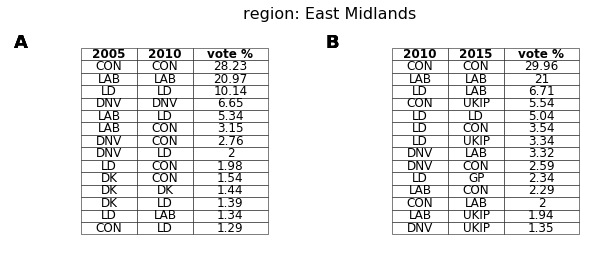
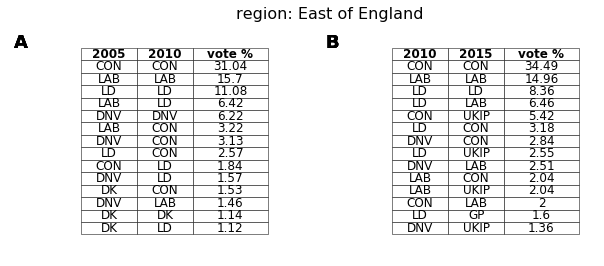
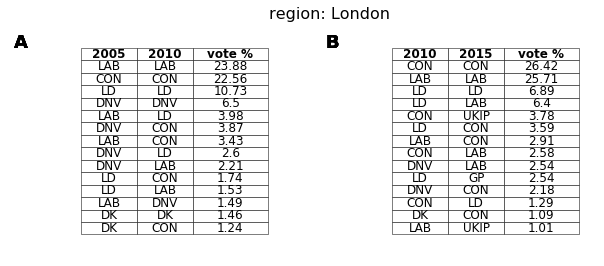
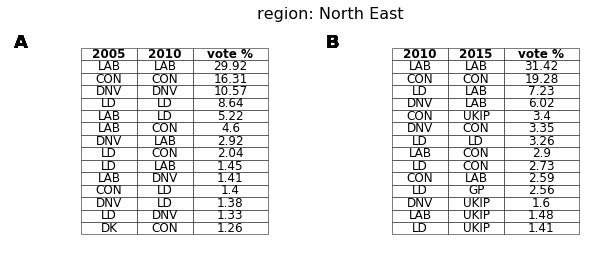
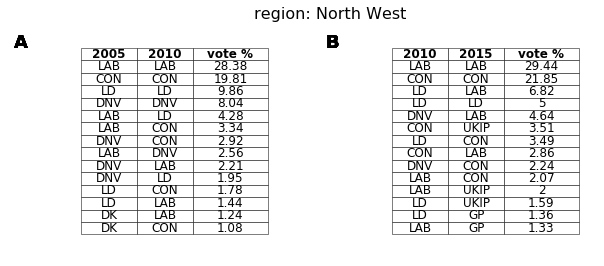
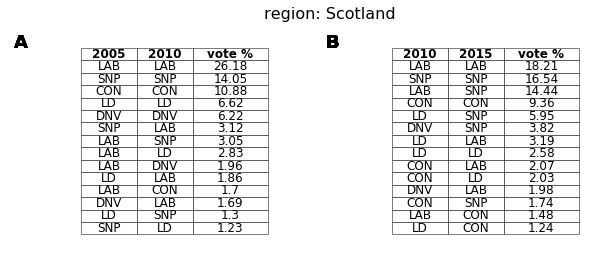
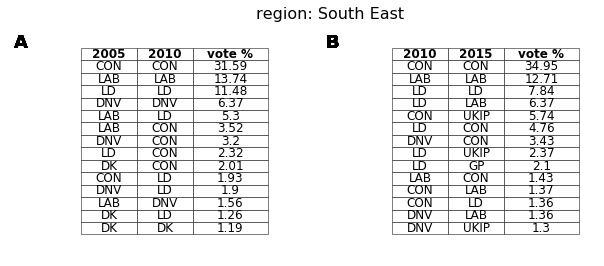
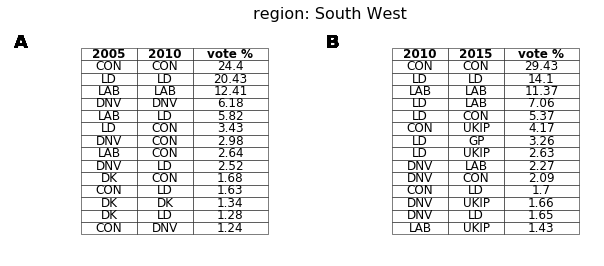
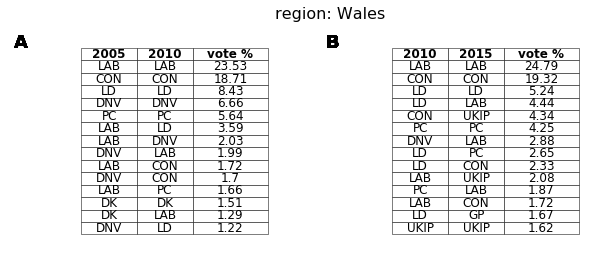
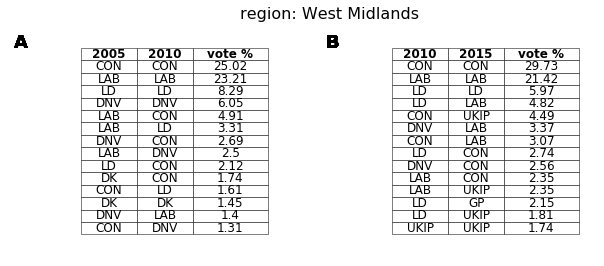
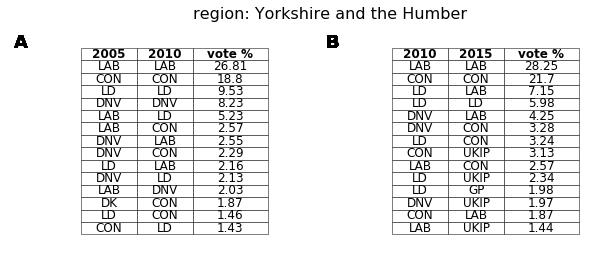

In [12]:
%%opts Table [fig_size=200]    
regions = list( BES_Panel["gor"].dropna().unique() )
x_dim = hv.Dimension("region",values = regions )
tables_2005_2010 = hv.HoloMap(kdims=["region"])
tables_2010_2015 = hv.HoloMap(kdims=["region"])
links_by_reg_2005_2010 = dict()
links_by_reg_2010_2015 = dict()
links_by_reg_2005_2015 = dict()



for reg in regions:
    
    BESreg = BES_Panel[ BES_Panel["gor"]==reg ]
    links_2005_2010 = []
    links_2005_2015 = []  
    
    
    # 2005 -> 2010, weighted
    first_elec  = "2005"
    second_elec = "2010"
    crosstab = pd.crosstab(index   = BESreg[ 'profile_past_vote_'+first_elec  ],
                           columns = BESreg[ 'profile_past_vote_'+second_elec ],
                           values  = BESreg[ "wt_full_W8" ],
                           aggfunc = sum,
                           normalize=True)*100
    tb = pd.DataFrame(columns = [ first_elec  , second_elec, '%'])
    
    tb_ind = 0
    for col in crosstab.columns:
        second_party = replace_list[ party_list.index( col ) ]
        for ind in crosstab[col].index:
            first_party = replace_list[ party_list.index( ind ) ]
            if crosstab[col][ind]>threshold:
                
                tb.loc[tb_ind] = [first_party, second_party, crosstab[col][ind].round(decimals=2)]
                tb_ind = tb_ind + 1
                
                d = {'source': first_party+first_elec,
                     'target': second_party+second_elec,
                     'value': crosstab[col][ind],
                     'color': colourmap[first_party]}
                links_2005_2010.append(d)
                links_2005_2015.append(d)
                
    tables_2005_2010[reg] = hv.Table(tb.sort_values(by='%', ascending=False)[0:14])
    links_by_reg_2005_2010[reg] = links_2005_2010
    ###########################################
    links_2010_2015 = []
      
    # 2010 -> 2015, weighted
    first_elec  = "2010"
    second_elec = "2015"    
    crosstab = pd.crosstab(index   = BESreg[ 'profile_past_vote_'+first_elec  ],
                           columns = BESreg[ 'profile_past_vote_'+second_elec ],
                           values  = BESreg[ "wt_full_W8" ],
                           aggfunc = sum,
                           normalize=True)*100
    tb = pd.DataFrame(columns = [ first_elec  , second_elec, '%'])
    links = []
    tb_ind = 0
    for col in crosstab.columns:
        second_party = replace_list[ party_list.index( col ) ]
        for ind in crosstab[col].index:
            first_party = replace_list[ party_list.index( ind ) ]
            if crosstab[col][ind]>threshold:
                
                tb.loc[tb_ind] = [first_party, second_party, crosstab[col][ind].round(decimals=2)]
                tb_ind = tb_ind + 1
                
                d = {'source': first_party+first_elec,
                     'target': second_party+second_elec,
                     'value' : crosstab[col][ind],
                     'color' : colourmap[first_party]}
                links_2010_2015.append(d)
                links_2005_2015.append(d)
                
    tables_2010_2015[reg] = hv.Table(tb.sort_values(by='%', ascending=False)[0:14])
    links_by_reg_2010_2015[reg] = links_2010_2015 
    links_by_reg_2005_2015[reg] = links_2005_2015

tables_2005_2010 + tables_2010_2015

In [14]:
reg = "Scotland"
print(reg)
sankey = SankeyWidget(links=links_by_reg_2005_2015[reg], margins=dict(top=0, bottom=0, left=70, right=70), scale=2 )
sankey

Scotland


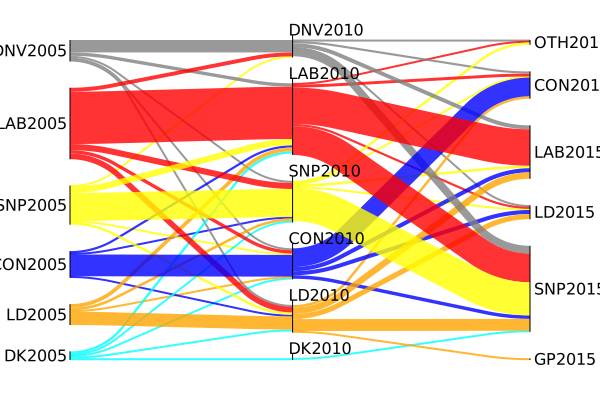

In [15]:
SVG(sankey.svg)

In [17]:
sankey.save_png(filename="scotland.png")

In [9]:
BES_numeric = pd.read_hdf( BES_data_folder+"BESW8numeric.hdf", "BESW8numeric" )
print("BES_numeric",  BES_numeric.shape )

BES_numeric (31409, 659)


In [10]:
fname = BES_data_folder+"cat_dictionary"+".pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
print("cat_dictionary", len( cat_dictionary ) )

cat_dictionary 650


In [13]:
BES_reduced_with_na = pd.read_hdf(BES_data_folder+"BES_reduced_with_na.hdf","BES_reduced_with_na")
print("BES_reduced_with_na",  BES_reduced_with_na.shape )

BES_reduced_with_na (31409, 454)


In [14]:
# for development, lets pare down the BES_Panel dataset to just the columns we're working with now
cols = ['profile_past_vote_2005',
        'profile_past_vote_2010',
        'profile_past_vote_2015',
        'generalElectionVote',
        'generalElectionVoteW9']
BES = BES_numeric[cols]
for col in cols:
    print(col)
    BES[col] = BES_numeric[col].apply( lambda x: replace_dict[cat_dictionary[col][x]]  if not np.isnan(x) else np.nan )

profile_past_vote_2005


C:\ANACON~1\envs\BES_analysis\lib\site-packages\pandas\indexes\base.py:1264: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)
C:\ANACON~1\envs\BES_analysis\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


profile_past_vote_2010
profile_past_vote_2015
generalElectionVote
generalElectionVoteW9


In [15]:
swingers = BES.apply(lambda x: len(x.dropna().unique())-1,axis=1)
swingers[swingers==-1]=0

In [16]:
gc.collect()

19

0        UKIP
1         CON
2         NaN
3         LAB
4         CON
5         CON
6         CON
7         SNP
8        UKIP
9        UKIP
10        LAB
11        CON
12        CON
13       UKIP
14       UKIP
15        SNP
16        CON
17        LAB
18       UKIP
19        LAB
20        CON
21        SNP
22        LAB
23        NaN
24        CON
25        NaN
26        CON
27        CON
28         GP
29        CON
         ... 
31379     LAB
31380     LAB
31381      GP
31382     LAB
31383      GP
31384    UKIP
31385      GP
31386     LAB
31387     LAB
31388     NaN
31389     NaN
31390     LAB
31391     CON
31392      GP
31393      LD
31394     LAB
31395     LAB
31396     NaN
31397    UKIP
31398     CON
31399     NaN
31400     NaN
31401     LAB
31402     NaN
31403      LD
31404     LAB
31405      PC
31406    UKIP
31407     LAB
31408     LAB
Name: generalElectionVote, dtype: object

In [32]:
party_now = BES["generalElectionVote"] ## on even of EU referendum!
party_now.notnull().sum()

25238

In [33]:
party_now=='LAB'

0        False
1        False
2        False
3         True
4        False
5        False
6        False
7        False
8        False
9        False
10        True
11       False
12       False
13       False
14       False
15       False
16       False
17        True
18       False
19        True
20       False
21       False
22        True
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
31379     True
31380     True
31381    False
31382     True
31383    False
31384    False
31385    False
31386     True
31387     True
31388    False
31389    False
31390     True
31391    False
31392    False
31393    False
31394     True
31395     True
31396    False
31397    False
31398    False
31399    False
31400    False
31401     True
31402    False
31403    False
31404     True
31405    False
31406    False
31407     True
31408     True
Name: generalElectionVote, dtype: bool

profile_past_vote_2005_Did not vote                                0.217748
marital_Married                                                    0.211792
euMemberJoin__Strongly agree                                       0.211437
profile_past_vote_2015_Scottish National Party (SNP)               0.202245
prevJob_Yes, I have done paid work in the past                     0.199664
profile_gross_personal__Â£100,000 and over                         0.196767
profile_past_vote_2015_Labour                                      0.196554
profile_past_vote_2010_Liberal Democrats                           0.193859
al_scale__Authoritarian                                            0.172685
profile_past_vote_2015_United Kingdom Independence Party (UKIP)    0.171635
al1__Strongly agree                                                0.171625
profile_past_vote_2005_Labour Party                                0.168549
euParlOverRide__Strongly agree                                     0.162900
EUIntegratio

profile_past_vote_2010_Green Party                                    -0.466095
profile_past_vote_2005_Green Party                                    -0.449604
profile_past_vote_2015_Green Party                                    -0.398026
marital_Never married                                                 -0.248427
workingStatus_Full time university student                            -0.237653
housing_Neither I live rent-free with my parents, family or friends   -0.211110
bestPM_Jeremy Corbyn                                                  -0.181387
profile_turnout_2015_No, did not vote                                 -0.179784
pccVote1_The Green candidate                                          -0.173818
euCloser__Strongly agree                                              -0.171794
likeCorbyn__Strongly like                                             -0.167531
partyId_Green Party                                                   -0.159657
noneuMore__Many more                    

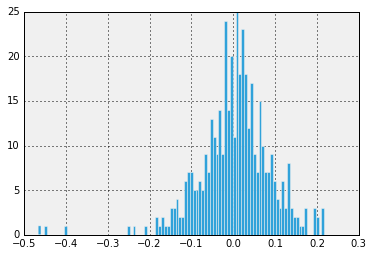

In [42]:
pnow = 'GP'
corr = BES_reduced_with_na[party_now==pnow].corrwith(swingers[party_now==pnow])
corr.sort_values().hist(bins=100)
display(corr[corr>.1].sort_values(ascending=False))
display(corr[corr<-.1].sort_values())

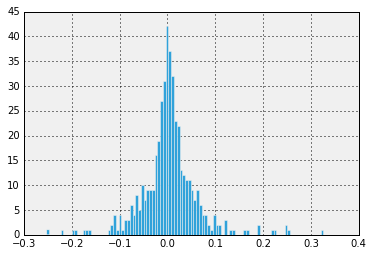

In [22]:
corr[corr>.08].sort_values()

profile_past_vote_2010_Some other party                            0.080515
profile_past_vote_2005_Green Party                                 0.080611
lr5__Strongly agree                                                0.080825
effectsEUEcon__Much better                                         0.083265
effectsEUNHS__Much better                                          0.083712
euRefVote_Leave the EU                                             0.089556
bestPM_Jeremy Corbyn                                               0.098411
partyId_No - none                                                  0.099349
lr2__Strongly agree                                                0.099712
partyId_Green Party                                                0.099766
lr3__Strongly agree                                                0.103307
profile_past_vote_2010_British National Party (BNP)                0.103698
immigCon__Allow many more                                          0.107552
partyIdEU__M

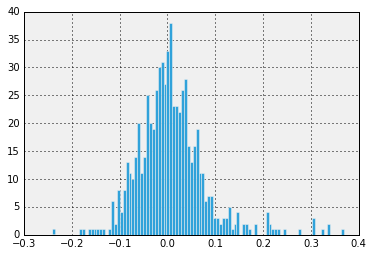

In [93]:
corr.sort_values().hist(bins=100)

In [108]:
corr[corr>.1].sort_values()

lr3                         0.103307
creditLeave_6W9             0.104275
immigCon                    0.107552
partyIdEU                   0.110990
EUContactLeaveNone          0.111015
partyContactUKIP            0.115045
ptvGrnW9                    0.116356
immigConW9                  0.116461
lr4                         0.121074
prPreferenceW9              0.123236
euID                        0.124656
partyContactUKIP_5          0.126438
efficacyPolCareW9           0.128294
profile_past_vote_2010      0.129817
efficacyPolCare             0.130385
scotElectionVoteList        0.130855
reasonNotRegistered_7       0.138103
achieveReduceImmigUKIPW9    0.141260
ptvGrn                      0.142304
euRefVotePost               0.145046
handleMIIUKIPW9             0.145260
bestOnMIIW9                 0.149440
EUContactRemainSNP          0.149968
likeFarageW9                0.157817
likeFarage                  0.158820
likeUKIPW9                  0.164365
likeUKIP                    0.166172
s

In [109]:
corr[corr<-.1]

likeCameron              -0.114115
likeOsborne              -0.109108
EUIntegrationCon         -0.112523
partyContactSNP_5        -0.143692
partyContactSNP_6        -0.104112
partyContactPC_5         -0.177449
partyContactUKIP_2       -0.136551
partyContactGreen_2      -0.155779
partyContactOther_7      -0.152578
satDemUK                 -0.110692
satDemEng                -0.120840
registeredUpToDate       -0.112817
reasonNotRegistered_4    -0.101512
reasonNotRegistered_5    -0.239837
ptvCon                   -0.113936
trustMPs                 -0.182127
pidWeTheyW9              -0.105646
pidMyPartyW9             -0.100373
pidPraiseGoodW9          -0.113196
likeCameronW9            -0.100247
trustMPsW9               -0.133293
conPriorities_immigW9    -0.104673
selfOccEmployeesLastW9   -0.165322
profile_turnout_2015     -0.101801
lr_scale                 -0.117361
dtype: float64

In [101]:
BES_Panel["bestOnMIIW8"].isnull().sum()

34259

In [106]:
BES_Panel["euRefVoteSqueezeW8"].unique()

[NaN, Leave the EU, Don't know, Stay/remain in the EU, I would/will not vote]
Categories (4, object): [Stay/remain in the EU < Leave the EU < I would/will not vote < Don't know]